In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats 
from datetime import datetime
from scipy.optimize import minimize
import yfinance as yf

Considérons dans un premier temps le cas d’un marché financier composé uniquement d’actifs risqués, l’univers d’investissement contient `n_assets` titres financiers risqués.


In [3]:
tickers  = ['V','PG',"JNJ","WMT","VZ","NEE",'KO','MSFT']
n_assets = len(tickers)
stocks   = yf.download(tickers)['Adj Close']['2021':]
stocks.dropna(inplace=True)

[*********************100%%**********************]  8 of 8 completed


<Axes: xlabel='Date'>

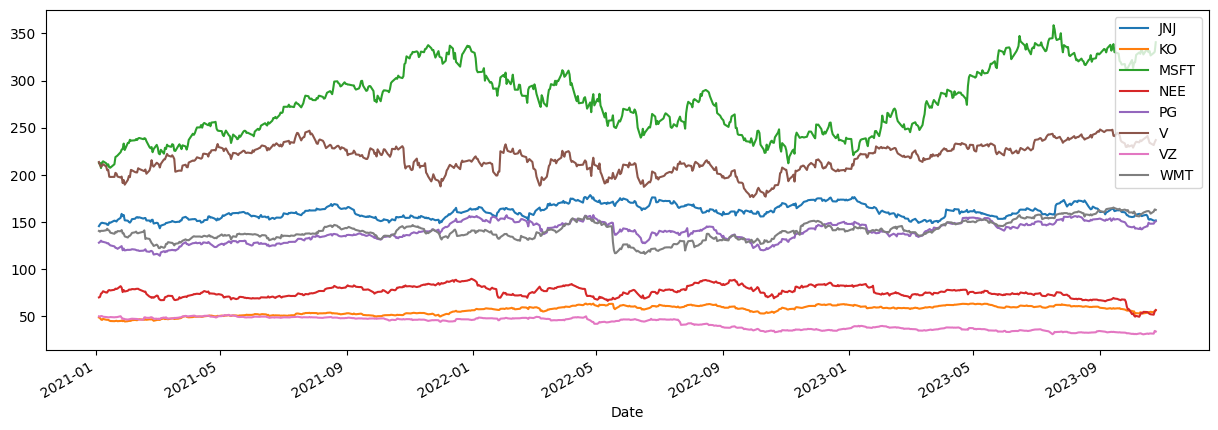

In [4]:
stocks.plot(figsize=(15,5))


Nous adaptons les notations suivantes :

  - $\boldsymbol{w} \in \mathbb{R}^{n\times 1}$ : un vecteur représentant les poids d'un portefeuille $P$.
  - $\boldsymbol{R} \in \mathbb{R}^{n\times 1}$ : un vecteur représentant les rentabilités aléatoires des actifs financiers de l'univers d'investissement. $\mathbb{E}[\boldsymbol{R}]$ désigne son espérance.
  - $\boldsymbol{e} \in \mathbb{R}^{n\times 1}$ : un vecteur dont toutes les composantes sont égales à $1$.
  - $V \in \mathbb{M}_n(\mathbb{R})$ : la matrice des variances-covariances des rentabilités des actifs financiers. On suppose que cette matrice est inversible.
$\sigma_i^2 = \sigma^2_i = \sigma^2(R_i)$ : variance de la rentabilité du $i$-ème actif financier.
$\sigma_{ij} = \text{Cov}(R_i, R_j)$ : covariance entre le taux de rendement du $i$-ème actif financier et le taux de rendement du $j$-ème actif financier.

En notation matricielle :
$$
\boldsymbol{w} =
\begin{pmatrix}
w_1 \\
\vdots \\
w_N
\end{pmatrix}, \quad
\mathbb{E}[\boldsymbol{R}] =
\begin{pmatrix}
\mathbb{E}[R_1] \\
\vdots \\
\mathbb{E}[R_N]
\end{pmatrix}, \quad
\boldsymbol{e} =
\begin{pmatrix}
1 \\
\vdots \\
1
\end{pmatrix}, \quad
\boldsymbol{V} =
\begin{pmatrix}
\sigma_{11} & \cdots & \sigma_{1N} \\
\vdots & \ddots & \vdots \\
\sigma_{N1} & \cdots & \sigma_{NN}
\end{pmatrix}
$$

Il faut également noter que notre matrice des variances-covariances est symétrique, c’est-à-dire que $V = V^T$.

Il s’agit d’obtenir l’ensemble des portefeuilles qui, pour chaque niveau donné d’espérance de rentabilité, ont une variance minimale. De façon alternative, on peut chercher l’ensemble des portefeuilles qui, pour chaque niveau donné de variance, exhibent l’espérance de rentabilité maximale.


# statistiques des actifs

## Rendements

In [5]:
def compute_returns(s):
    '''
    Computes the returns (percentage change) of a Dataframe of Series. 
    In the former case, it computes the returns for every column (Series) by using pd.aggregate
    '''
    if isinstance(s, pd.DataFrame):
        return s.aggregate( compute_returns )
    elif isinstance(s, pd.Series):
        return s / s.shift(1) - 1
    else:
        raise TypeError("Expected pd.DataFrame or pd.Series")

In [6]:
daily_R=compute_returns(stocks)
daily_R

,JNJ,KO,MSFT,NEE,PG,V,VZ,WMT
Date,,,,,,,,
2021-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-01-05,0.011757,-0.010993,0.000965,0.007411,0.006385,-0.014925,-0.004588,-0.005323
2021-01-06,0.009410,-0.031813,-0.025929,0.048950,0.010527,-0.008811,0.012120,0.006244
2021-01-07,0.003379,-0.011085,0.028457,0.010965,-0.009346,0.005597,-0.002250,-0.000068
2021-01-08,-0.002058,0.022418,0.006093,0.023206,-0.000432,0.007670,-0.012472,-0.000136
...,...,...,...,...,...,...,...,...
2023-10-19,-0.002684,0.005550,0.003666,-0.015965,-0.005628,-0.015412,0.017069,-0.004767
2023-10-20,0.004464,0.004048,-0.014035,-0.008208,-0.001349,-0.001839,-0.000317,-0.012502
2023-10-23,-0.010523,-0.008979,0.008112,-0.008468,0.000675,-0.007927,-0.005702,0.014172


## Rendements annualisés 

In [15]:
def annualize_from_daily_rets(s, periods_per_year):
    '''
    Computes the return per year, or, annualized return.
    The variable periods_per_year can be, e.g., 12, 52, 252, in 
    case of monthly, weekly, and daily data.
    The method takes in input either a DataFrame or a Series and, in the former 
    case, it computes the annualized return for every column (Series) by using pd.aggregate
    '''
    if isinstance(s, pd.DataFrame):
        return s.aggregate(annualize_from_daily_rets, periods_per_year=periods_per_year )
    elif isinstance(s, pd.Series):
        growth = (1 + s).prod()
        n_period_growth = s.shape[0]
        return growth**(periods_per_year/n_period_growth) - 1

In [16]:
annualized_return = annualize_from_daily_rets(daily_R,252)
annualized_return

JNJ     0.014604
KO      0.052990
MSFT    0.183070
NEE    -0.073065
PG      0.059775
V       0.037517
VZ     -0.129391
WMT     0.054034
dtype: float64

## Portefeuille de variance minimale

La variance de la rentabilité du portefeuille $P$ est donnée par l’expression :

$\sigma^2(R_P) = \boldsymbol{w}^T \boldsymbol{V} \boldsymbol{w}$.

In [236]:
def portfolio_volatility(cov_returns,weights,periods_per_year=252): 
    return annualize_vol((weights.T @ cov_returns @ weights)**(0.5),periods_per_year)


La première question que se pose un investisseur est évidemment de savoir : quel portefeuille efficient offre le niveau de risque le plus faible ? Il s’agit d’optimiser le programme quadratique suivant :

\[
\begin{cases}
    \min(\boldsymbol{w}^T \boldsymbol{V} \boldsymbol{w}) \\
    \text{s.c. } \boldsymbol{w}^T \boldsymbol{e} = 1
\end{cases}
\]

La contrainte est simplement une contrainte de budget indiquant que la somme des poids est égale à 1, c’est-à-dire 100\%.

Signalons toutefois que les poids peuvent être négatifs, ce qui signifie que les ventes à découvert sont autorisées.



In [ ]:
def minimize_volatility(rets, covmatrix, target_return=None):
    '''
    Returns the optimal weights of the minimum volatility portfolio on the effient frontier. 
    If target_return is not None, then the weights correspond to the minimum volatility portfolio 
    having a fixed target return. 
    The method uses the scipy minimize optimizer which solves the minimization problem 
    for the volatility of the portfolio
    '''
    n_assets = rets.shape[0]    
    # initial guess weights
    init_guess = np.repeat(1/n_assets, n_assets)
    weights_constraint = {
        "type": "eq",
        "fun": lambda w: 1.0 - np.sum(w)  
    }
    if target_return is not None:
        return_constraint = {
            "type": "eq",
            "args": (rets,),
            "fun": lambda w, r: target_return - (w @ r)
        }
        constr = (return_constraint, weights_constraint)
    else:
        constr = weights_constraint
        
    result = minimize(portfolio_volatility, 
                      init_guess,
                      args = (covmatrix,),
                      method = "SLSQP",
                      options = {"disp": False},
                      constraints = constr,
                      bounds = ((0.0,1.0),)*n_assets ) # bounds of each individual weight, i.e., w between 0 and 1
    return result.x

## simulation des portefeuilles

In [228]:
def annualize_vol(s, periods_per_year, ddof=1):
    '''
    Computes the volatility per year, or, annualized volatility.
    The variable periods_per_year can be, e.g., 12, 52, 252, in 
    case of monthly, weekly, and daily data.
    The method takes in input either a DataFrame, a Series, a list or a single number. 
    In the former case, it computes the annualized volatility of every column 
    (Series) by using pd.aggregate. In the latter case, s is a volatility 
    computed beforehand, hence only annulization is done
    '''
    if isinstance(s, pd.DataFrame):
        return s.aggregate(annualize_vol, periods_per_year=periods_per_year )
    elif isinstance(s, pd.Series):
        return s.std(ddof=ddof) * (periods_per_year)**(0.5)
    elif isinstance(s, list):
        return np.std(s, ddof=ddof) * (periods_per_year)**(0.5)
    elif isinstance(s, (int,float)):
        return s * (periods_per_year)**(0.5)

In [229]:
# compute the mean daily returns and the covariance of daily returns of the two assets
mean_rets = daily_R.mean()
std_rets  = daily_R.std()
cov_rets  = daily_R.cov()
corr_rets = daily_R.corr()
corr_rets

,JNJ,KO,MSFT,NEE,PG,V,VZ,WMT
JNJ,1.000000,0.468071,0.202039,0.296452,0.512087,0.249645,0.278849,0.327894
KO,0.468071,1.000000,0.348204,0.399890,0.679981,0.414440,0.361490,0.407816
MSFT,0.202039,0.348204,1.000000,0.362932,0.323303,0.500290,0.133008,0.265292
NEE,0.296452,0.399890,0.362932,1.000000,0.425192,0.254960,0.315281,0.291731
PG,0.512087,0.679981,0.323303,0.425192,1.000000,0.348024,0.366008,0.414652
V,0.249645,0.414440,0.500290,0.254960,0.348024,1.000000,0.237977,0.196198
VZ,0.278849,0.361490,0.133008,0.315281,0.366008,0.237977,1.000000,0.231993
WMT,0.327894,0.407816,0.265292,0.291731,0.414652,0.196198,0.231993,1.000000


In [230]:
weights = np.random.random(n_assets)

weights /= np.sum(weights)

weights

array([0.21213193, 0.0417466 , 0.18568845, 0.11873975, 0.04380871,
       0.14435654, 0.07605862, 0.1774694 ])

In [231]:
portfolio_ret= weights @ annualized_return
portfolio_ret

0.038410971407795924

In [238]:
portfolio_volatility(cov_rets,weights)

0.14289969355304183

In [235]:
portfolio_vol =  annualize_vol((weights.T @ cov_rets @ weights)**(0.5),252)
portfolio_vol


0.14289969355304183

In [219]:
weights

array([0.12819955, 0.23399937, 0.05278066, 0.14991566, 0.22838297,
       0.06427227, 0.07482421, 0.06762532])

In [239]:
periods_per_year = 252
num_portfolios   = 4000
portfolios       = pd.DataFrame(columns=["return","volatility"]+[f'w{i}' for i in range(1,n_assets+1)])
portfolios

,return,volatility,w1,w2,w3,w4,w5,w6,w7,w8


In [199]:
for i in range(num_portfolios):
    # select random weights
    weights = np.random.random(n_assets)
    weights /= np.sum(weights)
    
    # annualized portfolio returns
    portfolio_ret = weights @ annualized_return

    # annualized portfolio volatility
    portfolio_vol = annualize_vol((weights.T @ cov_rets @ weights)**(0.5),periods_per_year)
  
    # create dataframe   
    portfolios.loc[i]=[portfolio_ret,portfolio_vol]+ [weights[i-1] for i in range(1,n_assets+1)]
                                    
        

In [202]:
portfolios.tail()

,return,volatility,w1,w2,w3,w4,w5,w6,w7,w8
39995,0.002610,0.141065,0.046548,0.155497,0.023211,0.163224,0.099404,0.189748,0.158718,0.163649
39996,0.038845,0.140576,0.172554,0.180834,0.196622,0.064899,0.100170,0.116063,0.130718,0.038139
39997,0.006410,0.142441,0.030188,0.211315,0.087926,0.119216,0.089704,0.176535,0.218103,0.067013
39998,-0.003171,0.136079,0.142040,0.056206,0.048959,0.114847,0.063761,0.177460,0.221896,0.174832
39999,0.023016,0.138841,0.128200,0.233999,0.052781,0.149916,0.228383,0.064272,0.074824,0.067625


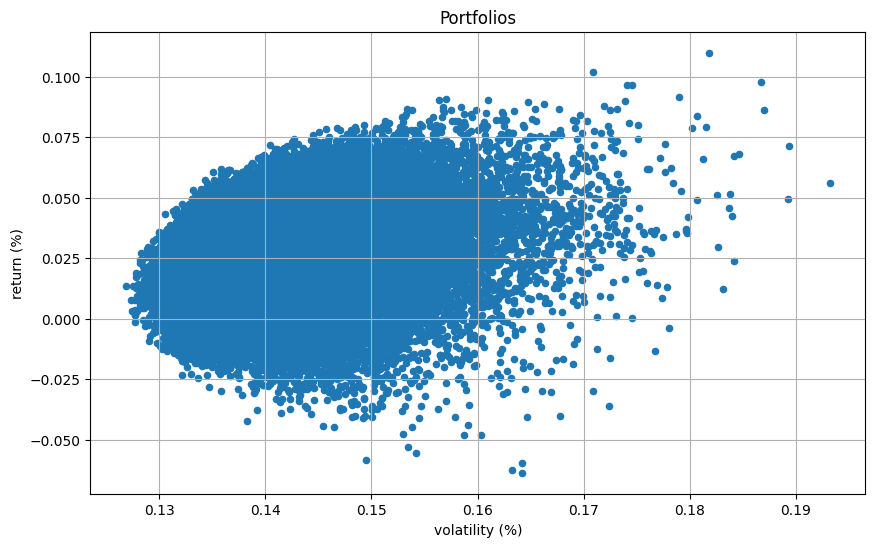

In [203]:
fig, ax = plt.subplots(1,1, figsize=(10,6)) 

im = ax.scatter(portfolios["volatility"], portfolios["return"], s=20)
ax.set_title("Portfolios")
ax.set_ylabel("return (%)")
ax.grid()

ax.set_xlabel("volatility (%)")
plt.show()

In [ ]:
def optimal_weights(n_points, rets, covmatrix, periods_per_year):
    '''
    Returns a set of n_points optimal weights corresponding to portfolios (of the efficient frontier) 
    with minimum volatility constructed by fixing n_points target returns. 
    The weights are obtained by solving the minimization problem for the volatility. 
    '''
    target_rets = np.linspace(rets.min(), rets.max(), n_points)    
    weights = [minimize_volatility(rets, covmatrix, target) for target in target_rets]
    return weights

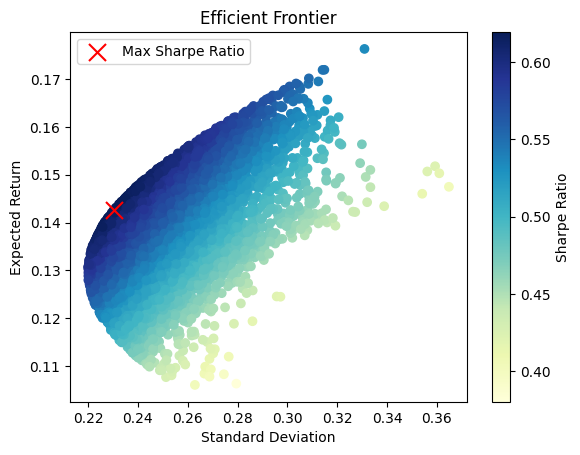

In [215]:
def efficient_frontier(n_portfolios, rets, covmat, periods_per_year):
    '''
    Returns (and plots) the efficient frontiers for a portfolio of rets.shape[1] assets. 
    The method returns a dataframe containing the volatilities, returns, sharpe ratios and weights 
    of the portfolios as well as a plot of the efficient frontier in case iplot=True. 
    Other inputs are:
        hsr: if true the method plots the highest return portfolio,
        cml: if True the method plots the capital market line;
        mvp: if True the method plots the minimum volatility portfolio;
        ewp: if True the method plots the equally weigthed portfolio. 
    The variable periods_per_year can be, e.g., 12, 52, 252, in case of monthly, weekly, and daily data.
    '''   
        
    ann_rets = annualize_from_daily_rets(rets, periods_per_year)
    
    # generates optimal weights of porfolios lying of the efficient frontiers
    weights = optimal_weights(n_portfolios, ann_rets, covmat, periods_per_year) 

    # portfolio returns
    portfolio_ret = [w @ annualized_return for w in weights]
    
    # portfolio volatility
    vols          = [portfolio_volatility(covmat,w) for w in weights] 
    portfolio_vol = [annualize_vol(v, periods_per_year) for v in vols]
    
    # portfolio sharpe ratio
    
    df = pd.DataFrame({"volatility": portfolio_vol,
                       "return": portfolio_ret})
    df = pd.concat([df, pd.DataFrame(weights)],axis=1)
    
    return df